# TP 2-3 : Branch-and-bound applied to a knapsack problem

### Initialisation (à faire une seule fois)

In [2]:
import Pkg; 
Pkg.add("GraphRecipes"); Pkg.add("Plots"); 
using GraphRecipes, Plots #only used to visualize the search tree at the end of the branch-and-bound

    Updating registry at `~/.julia/registries/General.toml`


   Resolving package versions...


  No Changes to `~/.julia/environments/v1.8/Project.toml`
  No Changes to `~/.julia/environments/v1.8/Manifest.toml`


   Resolving package versions...


  No Changes to `~/.julia/environments/v1.8/Project.toml`
  No Changes to `~/.julia/environments/v1.8/Manifest.toml`


### Récupération des données

In [3]:
function readKnaptxtInstance(filename)
    price=[]
    weight=[]
    KnapCap=[]
    open(filename) do f
        for i in 1:3
            tok = split(readline(f))
            if(tok[1] == "ListPrices=")
                for i in 2:(length(tok)-1)
                    push!(price,parse(Int64, tok[i]))
                end
            elseif(tok[1] == "ListWeights=")
                for i in 2:(length(tok)-1)
                    push!(weight,parse(Int64, tok[i]))
                end
            elseif(tok[1] == "Capacity=")
                push!(KnapCap, parse(Int64, tok[2]))
            else
                println("Unknown read :", tok)
            end 
        end
    end
    capacity=KnapCap[1]
    return price, weight, capacity
end

readKnaptxtInstance (generic function with 1 method)

### Tests de sondabilités TA, TO et TR basés sur le modèle linéaire

In [4]:
function TestsSondabilite_LP(model2, BestProfit, Bestsol)
    TA, TO, TR = false, false, false
    if(model2.infeasible)#Test d'admissibilité
        TA=true
        println("TA")
        
    elseif(model2.bound <= BestProfit) #Test d'optimalite
        TO=true
        println("TO")
    elseif(allVariableLock(model2)) #Test de resolution
        TR=true
        println("TR")
        #if (value(benef) >= BestProfit)
        actualProfit = objective_value(model2)
        if (actualProfit >= BestProfit)
            Bestsol = getValue.(model2.variables)
            #BestProfit=value(benef)
            BestProfit= actualProfit
            println("\nNew Solution memorized ", Bestsol, " with bestprofit ", BestProfit, "\n")
        end
    else
        println("non sondable")
    end
    TA, TO, TR, Bestsol, BestProfit
end

TestsSondabilite_LP (generic function with 1 method)

## Procédure de séparation (branching) et stratégie d'exploration permettant de se placer au prochain noeud à traiter

In [5]:

function SeparerNoeud_lexicographic_depthfirst!(model2, listobjs, listvals, n)
    # this node is non-sondable. Apply the branching criterion to separate it into two subnodes
    # and choose the child-node at the left  
    
    # lexicographic branching criterion: branch on the 1st object not yet fixed
    local newObj
    i, index = 1, 0
    while((i <= n) && (index==0)) 
        obj = model2.variables[i]
        if(!obj.lock)
            index=i
            setObj(model2, obj, 1.0)
            newObj = obj
        end
        i+=1
    end
    println("\nbranch on object ", newObj, "\n")

    # depthfirst exploration strategy: the node selected will be the most left of the child-nodes just created
    push!(listobjs,newObj) #save the identity of the object selected for branching
    push!(listvals,1.0) #save the node selected, identified by the value assigned to the variable/object chosen
    return listobjs, listvals
end


function ExplorerAutreNoeud_depthfirst!(model2, listobjs, listvals, listnodes)
    #this node is sondable, go back to parent node then right child if possible
    
    stop=false
    #check if we are not at the root node
    if (length(listobjs)>= 1)
        #go back to parent node
        obj=pop!(listobjs)
        theval=pop!(listvals)
        tmp=pop!(listnodes)
        lockObj(model2, obj)

        #go to right child if possible, otherwise go back to parent
        while( (theval==0.0) && (length(listobjs)>= 1))
            obj=pop!(listobjs)
            theval=pop!(listvals)
            tmp=pop!(listnodes)
            lockObj(model2, obj)
        end
        if theval==1.0
            setObj(model2, obj, 0.0)
            push!(listobjs,obj)
            push!(listvals,0.0)
        else
            println("\nFINISHED")
            stop=true
        end
    else
        #the root node was sondable
        println("\nFINISHED")
        stop=true
    end
    return listobjs, listvals, listnodes, stop 
end

ExplorerAutreNoeud_depthfirst! (generic function with 1 method)

###  Création de la relaxation linéaire (= modèle associé au noeud 0): 

In [6]:
mutable struct objDecision
    value::Float64
    index::Int64
    lock::Bool

end

function getValue(obj)
    return obj.value
end

function getName(obj)
    return string("x[", obj.index, "]")
end

mutable struct modelBase
    boundChoice::String
    variables::Array{objDecision, 1}
    nbFree::Int64
    capacity::Int64
    prices::Array{Int64, 1}
    weights::Array{Int64, 1}
    infeasible::Bool
    bound::Float64
end

function objective_value(model)
    return sum([obj.value * model.prices[obj.index] for obj in model.variables])
end

function actualWeight(model)
    return mapreduce(obj -> (!obj.lock ? 0. : obj.value) * model.weights[obj.index], +, model.variables, init = 0)
end

function resolution(model)
    residualCapacity = model.capacity - actualWeight(model)
    infeasible = !(residualCapacity >= 0.1)
    bound = -1

    if !infeasible
        #Calcul du prix actuel se trouvant dans le sac
        bound = mapreduce(obj -> (!obj.lock ? 0. : obj.value) * model.prices[obj.index], +, model.variables, init = 0)
        i, index = 1, 0
        while((i<= length(model.weights)) && (index ==0))
            obj = model.variables[i]
            if !obj.lock
                index=i
                bound += residualCapacity * (model.prices[obj.index] / model.weights[obj.index])
            end
            i += 1
        end
    end
    model.infeasible = infeasible
    model.bound = bound
end

function allVariableLock(model)
    if (model.nbFree == 1)
        i, index = 1, 0
        while((i<= length(model.weights)) && (index ==0))
            obj = model.variables[i]
            if !obj.lock
                index=i
                residualCapacity = model.capacity - actualWeight(model)
                obj.value = model.weights[obj.index] <=  residualCapacity  ? 1.0 : 0.0
            end
            i += 1
        end
    end

    return (model.nbFree == 1)
end

function lockObj(model, obj)
    model.nbFree += 1
    obj.lock = false
end

function setObj(model, obj, value)
    obj.lock = true
    obj.value = value
    model.nbFree -= 1
end

function CreationModele_LP(boundChoice, price,weight, capacity)
    n = length(price)
    perm = sortperm(price ./ weight, rev = true)
    vars = Array{objDecision, 1}(undef, n)
    for i = 1:n
        vars[i] = objDecision(0.0, i, false)
    end
    model2 = modelBase(boundChoice, view(vars, perm),n , capacity, price, weight, false, -1)
    
    return model2
end


CreationModele_LP (generic function with 1 method)

### Boucle principale : résoudre une relaxation, appliquer les tests de sondabilité, identifier le prochain noeud, répéter.

In [7]:

function SolveKnapInstance(filename)

    price, weight, capacity = readKnaptxtInstance(filename)

    model2 = CreationModele_LP("simpl", price, weight, capacity)

    #create the structure to memorize the search tree for visualization at the end
    trParentnodes=Int64[] #will store orig node of arc in search tree
    trChildnodes=Int64[] #will store destination node of arc in search tree
    trNamenodes=[] #will store names of nodes in search tree

    #intermediate structure to navigate in the search tree
    listobjs=[]
    listvals=[]
    listnodes=[]

    BestProfit=-1
    Bestsol=[]

    current_node_number=0
    stop = false

    while(!stop)

        println("\nNode number ", current_node_number, ": \n---------------\n")

        #Update the graphical tree
        push!(trNamenodes,current_node_number+1) 
        if(length(trNamenodes)>=2)
            push!(trParentnodes,listnodes[end]+1) # +1 because the 1st node is "node 0"
            push!(trChildnodes, current_node_number+1) # +1 because the 1st node is "node 0"
        end
        push!(listnodes, current_node_number)

        
        #create LP of current node
        resolution(model2)
        
    
        
        #print("Solve the LP model of the current node to compute its bound: start ... ")
        #status = optimize!(model2)
        #println("... end"); 

        print(": Solution LP")
        if(model2.infeasible)#(has_values(model2))
            print(" : NOT AVAILABLE (probably infeasible or ressources limit reached)")
        else
            print(" ", objective_value(model2))
            [print("\t", getName(v),"=",getValue(v)) for v in model2.variables] 
        end
        println(" "); 


        println("\nPrevious Solution memorized ", Bestsol, " with bestprofit ", BestProfit, "\n")

        TA, TO, TR, Bestsol, BestProfit = TestsSondabilite_LP(model2, BestProfit, Bestsol)

        is_node_sondable = TA || TO || TR

        #Reset_LP!(model2, x, listobjs)

        if(!is_node_sondable)
            listobjs, listvals = SeparerNoeud_lexicographic_depthfirst!(model2, listobjs, listvals, length(price))
        else
            listobjs, listvals, listnodes, stop = ExplorerAutreNoeud_depthfirst!(model2, listobjs, listvals, listnodes)
        end

        current_node_number = current_node_number + 1
    end

    println("\n******\n\nOptimal value = ", BestProfit, "\n\nOptimal x=", Bestsol)

    [print("\t", getName(v),"=",getValue(v)) for v in model2.variables]
    return BestProfit, Bestsol, trParentnodes, trChildnodes, trNamenodes

end


SolveKnapInstance (generic function with 1 method)

### Affichage du résultat final


Node number 0: 
---------------

: Solution LP 0.0	x[2]=0.0	x[1]=0.0	x[4]=0.0	x[3]=0.0 

Previous Solution memorized 

Any[] with bestprofit -1

non sondable

branch on object 

objDecision(1.0, 2, true)


Node number 1: 
---------------

: Solution LP 40.0	x[2]=1.0	x[1]=0.0	x[4]=0.0	x[3]=0.0 

Previous Solution memorized Any[] with bestprofit -1

non sondable

branch on object objDecision(1.0, 1, true)


Node number 2: 
---------------

: Solution LP : NOT AVAILABLE (probably infeasible or ressources limit reached) 

Previous Solution memorized Any[] with bestprofit -1

TA

Node number 3: 
---------------

: Solution LP 40.0	x[2]=1.0	x[1]=0.0	x[4]=0.0	x[3]=0.0 

Previous Solution memorized Any[] with bestprofit -1

non sondable

branch on object objDecision(1.0, 4, true)


Node number 4: 
---------------

: Solution LP 65.0	x[2]=1.0	x[1]=0.0	x[4]=1.0	x[3]=0.0 

Previous Solution memorized Any[] with bestprofit -1

TR

New Solution memorized 

[1.0, 0.0, 1.0, 0.0] with bestprofit 65.0


Node number 5: 
---------------

: Solution LP 40.0	x[2]=1.0	x[1]=0.0	x[4]=0.0	x[3]=0.0 

Previous Solution memorized [1.0, 0.0, 1.0, 0.0] with bestprofit 65.0

TO

Node number 6: 
---------------

: Solution LP 0.0	x[2]=0.0	x[1]=0.0	x[4]=0.0	x[3]=0.0 

Previous Solution memorized [1.0, 0.0, 1.0, 0.0] with bestprofit 65.0

TO

FINISHED

******

Optimal value = 65.0

Optimal x=[1.0, 0.0, 1.0, 0.0]
	x[2]=0.0	x[1]=0.0	x[4]=0.0	x[3]=0.0
******

Optimal value = 65.0

Optimal x=[1.0, 0.0, 1.0, 0.0]


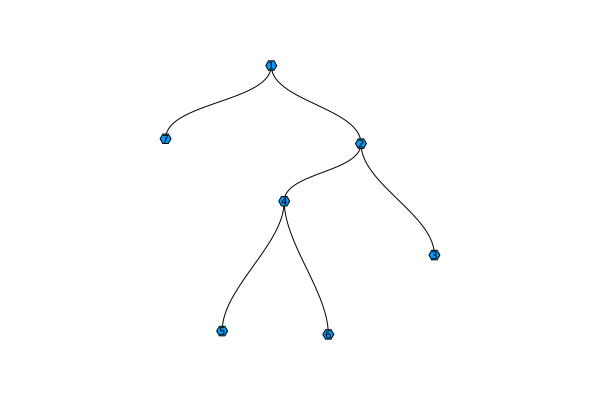

In [8]:
BestProfit, Bestsol, trParentnodes, trChildnodes, trNamenodes = SolveKnapInstance("instancesETU/KNAPnewformat/test.opb.txt")
println("\n******\n\nOptimal value = ", BestProfit, "\n\nOptimal x=", Bestsol)
graphplot(trParentnodes, trChildnodes, names=trNamenodes, method=:tree)